In [ ]:
!pip install spacy networkx matplotlib
!python -m spacy download en_core_web_sm
# python knowledge_graph_builder.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 129.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


KNOWLEDGE GRAPH CONSTRUCTION & EVALUATION DEMO

[STEP 1] Processing text and building knowledge graph...

KNOWLEDGE GRAPH SUMMARY

Total Nodes: 26
Total Edges: 16

--- NODES BY TYPE ---
PERSON: ['Sarah Chen', 'James Liu', 'Sarah', 'James', 'Maria Rodriguez', 'Maria']
ORG: ['the Ocean Research Institute', 'Stanford University']
GPE: ['San Francisco']
LOC: ['the Monterey Bay']
Trait: ['Openness_creative', 'Conscientiousness_ambitious', 'Conscientiousness_meticulous', 'Conscientiousness_organized', 'Extraversion_outgoing', 'Extraversion_enthusiastic', 'Extraversion_introverted', 'Extraversion_quiet', 'Conscientiousness_reliable', 'Agreeableness_kind', 'Agreeableness_compassionate', 'Neuroticism_calm', 'Neuroticism_stable', 'Extraversion_energetic', 'Openness_innovative', 'Conscientiousness_disciplined']

--- RELATIONSHIPS ---
Sarah Chen --[exhibits]--> Openness_creative
Sarah Chen --[exhibits]--> Conscientiousness_ambitious
James Liu --[exhibits]--> Conscientiousness_meticulous
James Liu 

/tmp/ipython-input-3290452616.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


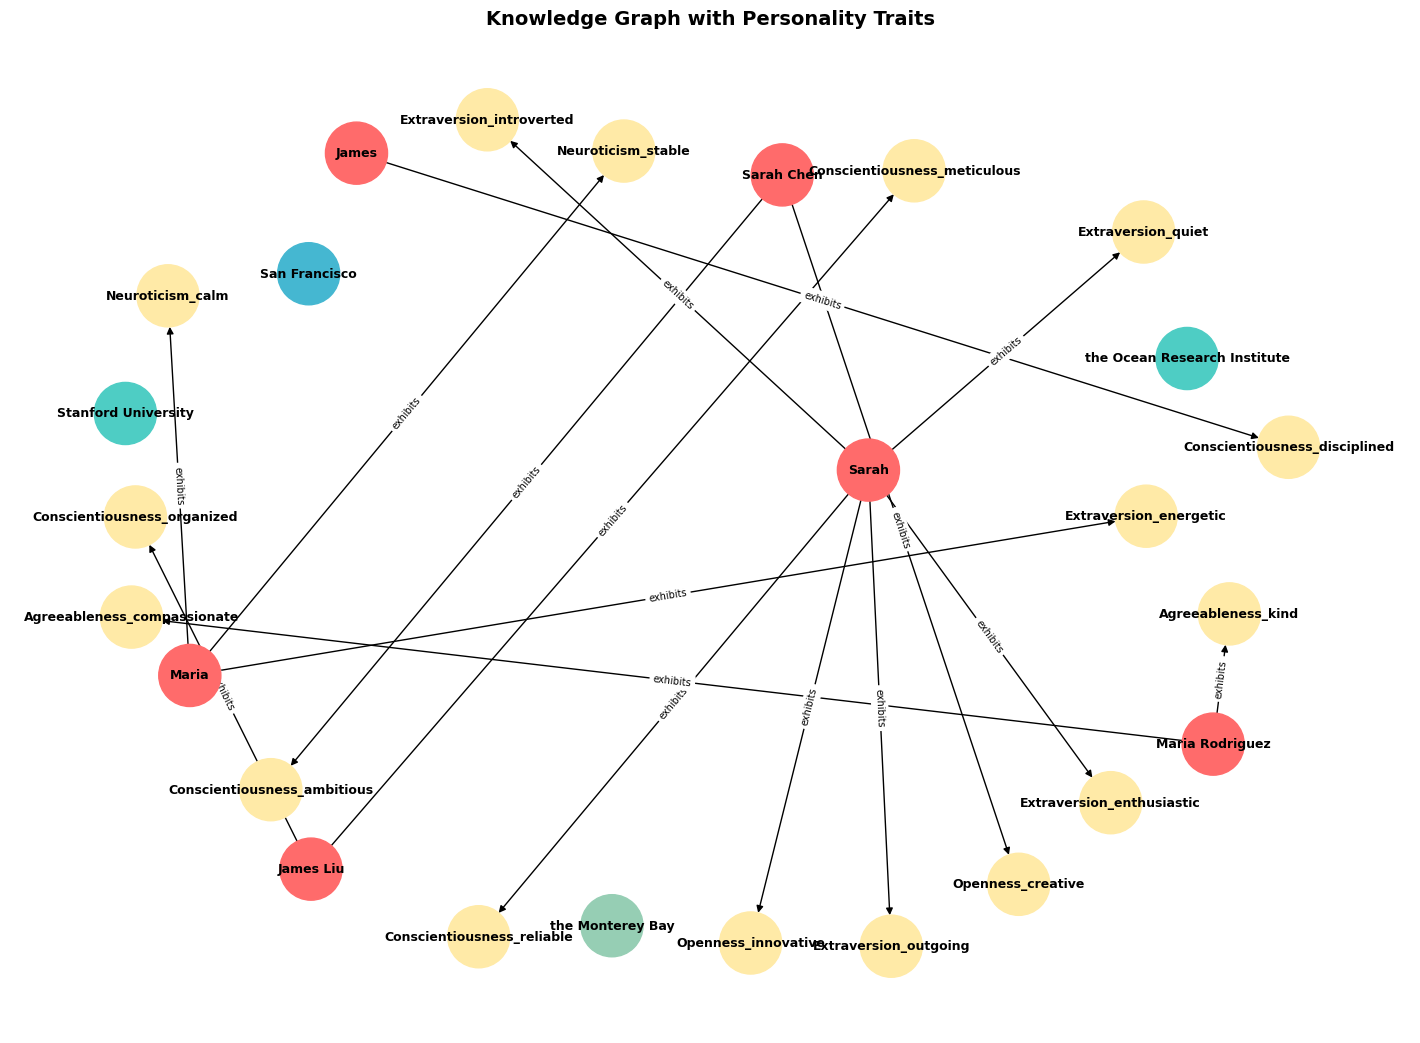


[STEP 3] Exporting graph...
✓ Graph exported to knowledge_graph.json
✓ Graph exported to knowledge_graph.graphml

[STEP 4] Running comprehensive evaluation...

COMPREHENSIVE KNOWLEDGE GRAPH EVALUATION

[1] ENTITY EXTRACTION METRICS
  precision: 0.5
  recall: 0.714
  f1_score: 0.588
  true_positives: 5
  false_positives: 5
  false_negatives: 2
  extracted_count: 10
  true_count: 7

[2] RELATIONSHIP EXTRACTION METRICS
  precision: 0
  recall: 0.0
  f1_score: 0
  exact_matches: 0
  partial_matches: 0
  extracted_count: 0
  true_count: 3

[3] PERSONALITY INFERENCE METRICS
  mean_absolute_error: 0.053
  trait_coverage: 1.0
  profile_completeness: 0.0
  people_with_traits: 6
  complete_profiles: 0
  target_mae: < 0.20 (Good)
  target_coverage: > 0.80 (Good)

[4] GRAPH STRUCTURE METRICS
  num_nodes: 26
  num_edges: 16
  density: 0.0246
  avg_degree: 1.23
  connected_components: 10
  isolated_nodes: 4
  clustering_coefficient: 0.0

[5] SEMANTIC COHERENCE ASSESSMENT
  Total relationships to as

In [ ]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import numpy as np
from typing import Dict, List, Tuple

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Personality adjective to Big Five mapping
PERSONALITY_TRAITS = {
    # Openness to Experience
    'creative': ('Openness', 0.8),
    'curious': ('Openness', 0.7),
    'imaginative': ('Openness', 0.8),
    'artistic': ('Openness', 0.9),
    'adventurous': ('Openness', 0.7),
    'innovative': ('Openness', 0.8),

    # Conscientiousness
    'organized': ('Conscientiousness', 0.8),
    'responsible': ('Conscientiousness', 0.8),
    'disciplined': ('Conscientiousness', 0.9),
    'meticulous': ('Conscientiousness', 0.9),
    'reliable': ('Conscientiousness', 0.8),
    'punctual': ('Conscientiousness', 0.7),
    'ambitious': ('Conscientiousness', 0.7),

    # Extraversion
    'outgoing': ('Extraversion', 0.8),
    'sociable': ('Extraversion', 0.8),
    'energetic': ('Extraversion', 0.7),
    'talkative': ('Extraversion', 0.8),
    'enthusiastic': ('Extraversion', 0.8),
    'introverted': ('Extraversion', -0.8),
    'shy': ('Extraversion', -0.7),
    'quiet': ('Extraversion', -0.6),

    # Agreeableness
    'kind': ('Agreeableness', 0.8),
    'cooperative': ('Agreeableness', 0.8),
    'compassionate': ('Agreeableness', 0.9),
    'friendly': ('Agreeableness', 0.7),
    'empathetic': ('Agreeableness', 0.9),
    'generous': ('Agreeableness', 0.8),
    'trusting': ('Agreeableness', 0.7),

    # Neuroticism
    'anxious': ('Neuroticism', 0.8),
    'nervous': ('Neuroticism', 0.7),
    'worried': ('Neuroticism', 0.7),
    'calm': ('Neuroticism', -0.8),
    'stable': ('Neuroticism', -0.8),
    'confident': ('Neuroticism', -0.7),
    'resilient': ('Neuroticism', -0.8),
}


class KnowledgeGraphBuilder:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.personality_scores = defaultdict(lambda: defaultdict(list))

    def extract_entities_and_relations(self, text):
        """Extract named entities and relationships using spaCy"""
        doc = nlp(text)

        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE', 'LOC']:
                self.graph.add_node(ent.text, type=ent.label_)

        for sent in doc.sents:
            for token in sent:
                if token.dep_ in ['nsubj', 'nsubjpass'] and token.head.pos_ == 'VERB':
                    subject = token.text
                    verb = token.head.text
                    for child in token.head.children:
                        if child.dep_ in ['dobj', 'pobj', 'attr']:
                            obj = child.text
                            if subject in self.graph.nodes and obj in self.graph.nodes:
                                self.graph.add_edge(subject, obj, relation=verb)
        return list(self.graph.nodes)

    def extract_personality_traits(self, text):
        """Extract personality adjectives and map to Big Five traits"""
        doc = nlp(text)
        for sent in doc.sents:
            person_entities = [ent.text for ent in sent.ents if ent.label_ == 'PERSON']
            for token in sent:
                if token.pos_ == 'ADJ':
                    adj_lower = token.lemma_.lower()
                    if adj_lower in PERSONALITY_TRAITS:
                        trait, score = PERSONALITY_TRAITS[adj_lower]
                        associated_person = person_entities[0] if person_entities else None
                        if associated_person:
                            self.personality_scores[associated_person][trait].append(score)
                            trait_node = f"{trait}_{adj_lower}"
                            self.graph.add_node(trait_node, type='Trait', trait_category=trait, adjective=adj_lower)
                            self.graph.add_edge(associated_person, trait_node, relation='exhibits', score=score)

    def aggregate_personality_scores(self):
        """Calculate average Big Five scores for each person"""
        aggregated = {}
        for person, traits in self.personality_scores.items():
            aggregated[person] = {}
            for trait, scores in traits.items():
                avg_score = sum(scores) / len(scores)
                normalized = (avg_score + 1) / 2
                aggregated[person][trait] = round(normalized, 2)
            if person in self.graph.nodes:
                self.graph.nodes[person]['personality'] = aggregated[person]
        return aggregated

    def visualize_graph(self, figsize=(14, 10)):
        """Visualize the knowledge graph with color-coded node types"""
        plt.figure(figsize=figsize)
        color_map = {
            'PERSON': '#FF6B6B',
            'ORG': '#4ECDC4',
            'GPE': '#45B7D1',
            'LOC': '#96CEB4',
            'Trait': '#FFEAA7'
        }
        node_colors = [
            color_map.get(self.graph.nodes[n].get('type', 'OTHER'), '#DFE6E9')
            for n in self.graph.nodes()
        ]
        pos = nx.spring_layout(self.graph, k=2, iterations=50, seed=42)
        nx.draw(self.graph, pos, with_labels=True, node_color=node_colors,
                node_size=2000, font_weight='bold', font_size=9)
        edge_labels = nx.get_edge_attributes(self.graph, 'relation')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, font_size=7)
        plt.title("Knowledge Graph with Personality Traits", fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def export_to_json(self, filename='knowledge_graph.json'):
        """Export graph to JSON format"""
        data = {'nodes': [], 'edges': []}
        for node in self.graph.nodes():
            node_data = {'id': node}
            node_data.update(self.graph.nodes[node])
            data['nodes'].append(node_data)
        for u, v in self.graph.edges():
            edge_data = {'source': u, 'target': v}
            edge_data.update(self.graph.edges[u, v])
            data['edges'].append(edge_data)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print(f"✓ Graph exported to {filename}")

    def export_to_graphml(self, filename='knowledge_graph.graphml'):
        """Export graph to GraphML format (convert unsupported types)"""
        G_clean = nx.DiGraph()
        for n, attrs in self.graph.nodes(data=True):
            clean_attrs = {k: (json.dumps(v) if isinstance(v, (dict, list, set, tuple)) else v)
                           for k, v in attrs.items()}
            G_clean.add_node(n, **clean_attrs)
        for u, v, attrs in self.graph.edges(data=True):
            clean_attrs = {k: (json.dumps(v) if isinstance(v, (dict, list, set, tuple)) else v)
                           for k, v in attrs.items()}
            G_clean.add_edge(u, v, **clean_attrs)
        nx.write_graphml(G_clean, filename)
        print(f"✓ Graph exported to {filename}")

    def print_summary(self):
        """Print summary of the knowledge graph"""
        print("\n" + "="*60)
        print("KNOWLEDGE GRAPH SUMMARY")
        print("="*60)
        print(f"\nTotal Nodes: {self.graph.number_of_nodes()}")
        print(f"Total Edges: {self.graph.number_of_edges()}")
        node_types = defaultdict(list)
        for node in self.graph.nodes():
            node_types[self.graph.nodes[node].get('type', 'OTHER')].append(node)
        print("\n--- NODES BY TYPE ---")
        for t, nodes in node_types.items():
            print(f"{t}: {nodes}")
        print("\n--- RELATIONSHIPS ---")
        for u, v, data in self.graph.edges(data=True):
            print(f"{u} --[{data.get('relation', 'related_to')}]--> {v}")
        print("\n--- PERSONALITY PROFILES (Big Five) ---")
        profiles = self.aggregate_personality_scores()
        for person, scores in profiles.items():
            print(f"\n{person}:")
            for trait, score in scores.items():
                print(f"  {trait}: {score}")


class KnowledgeGraphEvaluator:
    """Comprehensive evaluation suite for Knowledge Graph quality"""

    def __init__(self, kg_builder: KnowledgeGraphBuilder, ground_truth: Dict = None):
        self.kg = kg_builder
        self.graph = kg_builder.graph
        self.ground_truth = ground_truth or {}
        self.evaluation_results = {}

    # ============ QUANTITATIVE METRICS ============

    def calculate_entity_metrics(self) -> Dict:
        """Calculate entity extraction precision, recall, F1"""
        if 'entities' not in self.ground_truth:
            return {'status': 'No ground truth provided'}

        extracted_entities = set(n for n in self.graph.nodes()
                                if self.graph.nodes[n].get('type') in ['PERSON', 'ORG', 'GPE', 'LOC'])
        true_entities = set(self.ground_truth['entities'])

        true_positives = len(extracted_entities & true_entities)
        false_positives = len(extracted_entities - true_entities)
        false_negatives = len(true_entities - extracted_entities)

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'precision': round(precision, 3),
            'recall': round(recall, 3),
            'f1_score': round(f1, 3),
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'extracted_count': len(extracted_entities),
            'true_count': len(true_entities)
        }

    def calculate_relationship_metrics(self) -> Dict:
        """Calculate relationship extraction quality"""
        if 'relationships' not in self.ground_truth:
            return {'status': 'No ground truth provided'}

        # Extract relationships as (source, target, relation) tuples
        extracted_rels = set()
        for u, v, data in self.graph.edges(data=True):
            if self.graph.nodes[u].get('type') != 'Trait' and self.graph.nodes[v].get('type') != 'Trait':
                extracted_rels.add((u, v, data.get('relation', 'unknown')))

        true_rels = set(tuple(r) for r in self.ground_truth['relationships'])

        # Exact match
        exact_matches = len(extracted_rels & true_rels)

        # Partial match (ignore relation type)
        extracted_pairs = set((u, v) for u, v, _ in extracted_rels)
        true_pairs = set((u, v) for u, v, _ in true_rels)
        partial_matches = len(extracted_pairs & true_pairs)

        precision = exact_matches / len(extracted_rels) if extracted_rels else 0
        recall = exact_matches / len(true_rels) if true_rels else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'precision': round(precision, 3),
            'recall': round(recall, 3),
            'f1_score': round(f1, 3),
            'exact_matches': exact_matches,
            'partial_matches': partial_matches,
            'extracted_count': len(extracted_rels),
            'true_count': len(true_rels)
        }

    def calculate_personality_metrics(self) -> Dict:
        """Calculate personality inference accuracy (MAE and coverage)"""
        if 'personalities' not in self.ground_truth:
            return {'status': 'No ground truth provided'}

        personality_profiles = self.kg.aggregate_personality_scores()
        true_profiles = self.ground_truth['personalities']

        # Mean Absolute Error
        errors = []
        for person in true_profiles:
            if person in personality_profiles:
                for trait in ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']:
                    if trait in true_profiles[person] and trait in personality_profiles[person]:
                        error = abs(true_profiles[person][trait] - personality_profiles[person][trait])
                        errors.append(error)

        mae = np.mean(errors) if errors else 0

        # Coverage metrics
        people_with_traits = len(personality_profiles)
        total_people = len([n for n in self.graph.nodes() if self.graph.nodes[n].get('type') == 'PERSON'])
        coverage = people_with_traits / total_people if total_people > 0 else 0

        # Trait completeness (how many people have all 5 traits)
        complete_profiles = sum(1 for p in personality_profiles.values() if len(p) == 5)
        completeness = complete_profiles / people_with_traits if people_with_traits > 0 else 0

        return {
            'mean_absolute_error': round(mae, 3),
            'trait_coverage': round(coverage, 3),
            'profile_completeness': round(completeness, 3),
            'people_with_traits': people_with_traits,
            'complete_profiles': complete_profiles,
            'target_mae': '< 0.20 (Good)',
            'target_coverage': '> 0.80 (Good)'
        }

    def calculate_graph_structure_metrics(self) -> Dict:
        """Calculate graph connectivity and structural metrics"""
        num_nodes = self.graph.number_of_nodes()
        num_edges = self.graph.number_of_edges()

        # Density
        max_edges = num_nodes * (num_nodes - 1)
        density = num_edges / max_edges if max_edges > 0 else 0

        # Connected components
        undirected = self.graph.to_undirected()
        num_components = nx.number_connected_components(undirected)

        # Average degree
        degrees = [d for _, d in self.graph.degree()]
        avg_degree = np.mean(degrees) if degrees else 0

        # Isolated nodes
        isolated = [n for n in self.graph.nodes() if self.graph.degree(n) == 0]

        # Clustering coefficient
        clustering = nx.average_clustering(undirected) if num_nodes > 0 else 0

        return {
            'num_nodes': num_nodes,
            'num_edges': num_edges,
            'density': round(density, 4),
            'avg_degree': round(avg_degree, 2),
            'connected_components': num_components,
            'isolated_nodes': len(isolated),
            'clustering_coefficient': round(clustering, 3),
            'isolated_node_list': isolated[:5]  # Show first 5
        }

    # ============ QUALITATIVE METRICS ============

    def assess_semantic_coherence(self) -> Dict:
        """Manual assessment template for semantic coherence"""
        relationships = []
        for u, v, data in self.graph.edges(data=True):
            if self.graph.nodes[u].get('type') != 'Trait' and self.graph.nodes[v].get('type') != 'Trait':
                relationships.append({
                    'subject': u,
                    'relation': data.get('relation', 'unknown'),
                    'object': v,
                    'coherence_score': None  # To be filled manually
                })

        return {
            'total_relationships': len(relationships),
            'sample_relationships': relationships[:10],
            'instructions': 'Manually score each relationship 1-5 for plausibility',
            'target_avg_score': '> 4.0'
        }

    def check_personality_interpretability(self) -> Dict:
        """Check if personality inferences are explainable"""
        personality_profiles = self.kg.aggregate_personality_scores()

        interpretability_report = []
        for person, traits in personality_profiles.items():
            # Find evidence (connected trait nodes)
            evidence = []
            for neighbor in self.graph.neighbors(person):
                if self.graph.nodes[neighbor].get('type') == 'Trait':
                    adjective = self.graph.nodes[neighbor].get('adjective')
                    trait_cat = self.graph.nodes[neighbor].get('trait_category')
                    evidence.append(f"{adjective} → {trait_cat}")

            interpretability_report.append({
                'person': person,
                'traits': traits,
                'evidence': evidence,
                'evidence_count': len(evidence)
            })

        return {
            'profiles': interpretability_report,
            'avg_evidence_per_person': round(np.mean([p['evidence_count'] for p in interpretability_report]), 2) if interpretability_report else 0
        }

    def detect_hallucinations(self) -> Dict:
        """Detect potential hallucinated entities or relationships"""
        # Entities with very low confidence (isolated nodes might be errors)
        isolated = [n for n in self.graph.nodes()
                   if self.graph.degree(n) == 0 and self.graph.nodes[n].get('type') != 'Trait']

        # Relationships with unusual patterns
        unusual_relations = []
        for u, v, data in self.graph.edges(data=True):
            u_type = self.graph.nodes[u].get('type')
            v_type = self.graph.nodes[v].get('type')

            # Check for nonsensical combinations
            if u_type in ['ORG', 'GPE', 'LOC'] and v_type == 'Trait':
                unusual_relations.append((u, data.get('relation'), v))

        return {
            'isolated_entities': isolated,
            'unusual_relationships': unusual_relations,
            'hallucination_rate': len(unusual_relations) / self.graph.number_of_edges() if self.graph.number_of_edges() > 0 else 0
        }

    # ============ COMPOSITE EVALUATION ============

    def run_full_evaluation(self, verbose=True) -> Dict:
        """Run all evaluation metrics and generate comprehensive report"""
        print("\n" + "="*70)
        print("COMPREHENSIVE KNOWLEDGE GRAPH EVALUATION")
        print("="*70)

        # Quantitative Metrics
        print("\n[1] ENTITY EXTRACTION METRICS")
        entity_metrics = self.calculate_entity_metrics()
        self.evaluation_results['entity_metrics'] = entity_metrics
        if verbose:
            for k, v in entity_metrics.items():
                print(f"  {k}: {v}")

        print("\n[2] RELATIONSHIP EXTRACTION METRICS")
        rel_metrics = self.calculate_relationship_metrics()
        self.evaluation_results['relationship_metrics'] = rel_metrics
        if verbose:
            for k, v in rel_metrics.items():
                print(f"  {k}: {v}")

        print("\n[3] PERSONALITY INFERENCE METRICS")
        personality_metrics = self.calculate_personality_metrics()
        self.evaluation_results['personality_metrics'] = personality_metrics
        if verbose:
            for k, v in personality_metrics.items():
                print(f"  {k}: {v}")

        print("\n[4] GRAPH STRUCTURE METRICS")
        structure_metrics = self.calculate_graph_structure_metrics()
        self.evaluation_results['structure_metrics'] = structure_metrics
        if verbose:
            for k, v in structure_metrics.items():
                if k != 'isolated_node_list':
                    print(f"  {k}: {v}")

        # Qualitative Metrics
        print("\n[5] SEMANTIC COHERENCE ASSESSMENT")
        coherence = self.assess_semantic_coherence()
        self.evaluation_results['coherence'] = coherence
        print(f"  Total relationships to assess: {coherence['total_relationships']}")
        print(f"  Sample shown: {len(coherence['sample_relationships'])}")

        print("\n[6] PERSONALITY INTERPRETABILITY")
        interpretability = self.check_personality_interpretability()
        self.evaluation_results['interpretability'] = interpretability
        print(f"  Avg evidence per person: {interpretability['avg_evidence_per_person']}")

        print("\n[7] HALLUCINATION DETECTION")
        hallucinations = self.detect_hallucinations()
        self.evaluation_results['hallucinations'] = hallucinations
        print(f"  Isolated entities: {len(hallucinations['isolated_entities'])}")
        print(f"  Unusual relationships: {len(hallucinations['unusual_relationships'])}")

        # Overall Quality Score
        print("\n" + "="*70)
        print("OVERALL QUALITY ASSESSMENT")
        print("="*70)

        score_components = []
        weights = []

        if 'f1_score' in entity_metrics and entity_metrics['f1_score'] != 'No ground truth provided':
            score_components.append(entity_metrics['f1_score'])
            weights.append(0.25)

        if 'f1_score' in rel_metrics and rel_metrics['f1_score'] != 'No ground truth provided':
            score_components.append(rel_metrics['f1_score'])
            weights.append(0.25)

        if 'mean_absolute_error' in personality_metrics:
            # Convert MAE to 0-1 score (lower is better, so invert)
            mae_score = max(0, 1 - personality_metrics['mean_absolute_error'])
            score_components.append(mae_score)
            weights.append(0.20)

        if 'trait_coverage' in personality_metrics:
            score_components.append(personality_metrics['trait_coverage'])
            weights.append(0.15)

        # Graph quality (normalize clustering coefficient)
        score_components.append(structure_metrics['clustering_coefficient'])
        weights.append(0.15)

        if score_components:
            overall_score = sum(s * w for s, w in zip(score_components, weights)) / sum(weights)
            print(f"\n  Overall Quality Score: {overall_score:.3f} / 1.000")

            if overall_score >= 0.85:
                print("  Quality Level: ★★★★★ EXCELLENT")
            elif overall_score >= 0.70:
                print("  Quality Level: ★★★★☆ GOOD")
            elif overall_score >= 0.55:
                print("  Quality Level: ★★★☆☆ FAIR")
            else:
                print("  Quality Level: ★★☆☆☆ NEEDS IMPROVEMENT")
        else:
            print("\n  Overall Score: Cannot calculate (no ground truth)")

        print("\n" + "="*70)

        return self.evaluation_results

    def export_evaluation_report(self, filename='evaluation_report.json'):
        """Export evaluation results to JSON"""
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.evaluation_results, f, indent=2, ensure_ascii=False)
        print(f"\n✓ Evaluation report exported to {filename}")


# === Example Usage with Ground Truth ===
if __name__ == "__main__":
    example_text = """
    Dr. Sarah Chen is a creative and ambitious marine biologist who works at
    the Ocean Research Institute. She collaborated with Dr. James Liu, a
    meticulous and organized oceanographer from Stanford University. Sarah
    is very outgoing and enthusiastic when presenting her research, while
    James is more introverted and quiet but highly reliable.

    Their colleague, Maria Rodriguez, is a kind and compassionate data scientist
    who joined the team last year. Maria is calm and stable under pressure,
    which complements Sarah's energetic personality. The team works in
    San Francisco and frequently visits the Monterey Bay research station.

    Sarah mentored three graduate students and led an innovative coral reef
    restoration project. James designed the experimental protocols with his
    typical disciplined approach.
    """

    # Define ground truth for evaluation
    ground_truth = {
        'entities': [
            'Sarah Chen', 'James Liu', 'Maria Rodriguez',
            'Ocean Research Institute', 'Stanford University',
            'San Francisco', 'Monterey Bay'
        ],
        'relationships': [
            ('Sarah Chen', 'works', 'Ocean Research Institute'),
            ('Sarah Chen', 'collaborated', 'James Liu'),
            ('James Liu', 'works', 'Stanford University'),
        ],
        'personalities': {
            'Sarah Chen': {
                'Openness': 0.85,
                'Conscientiousness': 0.75,
                'Extraversion': 0.90,
                'Agreeableness': 0.70,
                'Neuroticism': 0.30
            },
            'James Liu': {
                'Openness': 0.60,
                'Conscientiousness': 0.90,
                'Extraversion': 0.25,
                'Agreeableness': 0.75,
                'Neuroticism': 0.35
            },
            'Maria Rodriguez': {
                'Openness': 0.70,
                'Conscientiousness': 0.80,
                'Extraversion': 0.60,
                'Agreeableness': 0.90,
                'Neuroticism': 0.25
            }
        }
    }

    print("="*70)
    print("KNOWLEDGE GRAPH CONSTRUCTION & EVALUATION DEMO")
    print("="*70)

    # Build Knowledge Graph
    print("\n[STEP 1] Processing text and building knowledge graph...")
    kg = KnowledgeGraphBuilder()
    kg.extract_entities_and_relations(example_text)
    kg.extract_personality_traits(example_text)
    kg.print_summary()

    # Visualize
    print("\n[STEP 2] Generating visualization...")
    kg.visualize_graph()

    # Export
    print("\n[STEP 3] Exporting graph...")
    kg.export_to_json()
    kg.export_to_graphml()

    # Evaluate
    print("\n[STEP 4] Running comprehensive evaluation...")
    evaluator = KnowledgeGraphEvaluator(kg, ground_truth)
    results = evaluator.run_full_evaluation(verbose=True)
    evaluator.export_evaluation_report()

    print("\n" + "="*70)
    print("✓ COMPLETE! All outputs saved.")
    print("="*70)